# Dinucleotide deletions at repeats - sequence context analysis

An examination of somatic dinucleotide deletions at repeats (STR) or
microhomology (SNMH) regions observed in RNase H2 null mouse tumours compared to
genomewide occurence of dinucleotide repeats/microhomology.

In [1]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from utils.utils import complement, df_to_group_counts
%matplotlib inline
sns.set_context('talk')

out_dir = "outputs/two_bp_deletion_sequence_context"
os.makedirs(out_dir, exist_ok=True)

# Identification of genomewide STR and MH sequences

Perfect (STR) and imperfect (MH) repeats are identified using the
`short_repeats_from_fasta` executable from the provided
[indel_repeat_classifier](https://git.ecdf.ed.ac.uk/Deletions_paper/indel_repeat_classifier)
package. Output from this is filtered using a bed of mappable regions using
100mers for the given genome as provided by 
[umap](https://bismap.hoffmanlab.org). Output CSVs are then available for
further processing. To generate counts of all repeat types and lengths observed
we use a combination of standard gnu `sort` and `uniq` utilities.

Example scripts for use on a SGE cluster (parallelising by chromosome) for these
steps are given below:

* Identify repeats in genome of interest

~~~
#!/bin/bash
#$ -V
#$ -cwd
#$ -l h_rt=24:00:00
#$ -l h_vmem=4G
#$ -t 1-24
#$ -o logs/
#$ -e logs/

if [ $# -ne 2 ]
then
    echo "Usage: qsub $0 <fasta> <output_prefix>"
    exit 1
fi

set -euo pipefail

fasta=$1
prefix=$2
chrom=$(awk "NR == $SGE_TASK_ID" <(cut -f 1 ${fasta}.fai))

outdir=$(dirname $prefix)
mkdir -p $outdir

echo $(date) Processing $fasta chromosome $chrom
indel_repeat_classifier/bin/short_repeats_from_fasta \
    $fasta \
    ${prefix}_${chrom} \
    -s $chrom

echo $(date) Done
echo $?
~~~

* Filter repeats using bed (e.g. of mappable regions)

~~~
#!/bin/bash
#$ -V
#$ -cwd
#$ -l h_rt=24:00:00
#$ -l h_vmem=4G
#$ -o logs/
#$ -j y

if [ $# -ne 3 ]
then
    echo "Usage: qsub -t 1-\$(ls <csv_dir>/*csv.gz | wc -l ) $0 <csv_dir> <out_dir> <bed>"
    exit 1
fi

set -euo pipefail

csv_dir=$1
out_dir=$2
bed=$3
csv=$(awk "NR == $SGE_TASK_ID" <(ls $csv_dir/*csv.gz))
out_csv=$out_dir/$(basename $csv .csv.gz).filtered.csv.gz

mkdir -p $out_dir

echo $(date) Filtering $csv to $out_csv

indel_repeat_classifier/bin/filter_repeat_csv_by_regions \
    $csv \
    $bed \
    -o $out_csv

echo $(date) Done
echo $?
~~~

* To create an easily parseable set of counts of repeat types:

~~~
#!/bin/bash
#$ -V
#$ -cwd
#$ -l h_rt=24:00:00
#$ -l h_vmem=4G
#$ -o logs/
#$ -j y

if [ $# -ne 2 ]
then
    echo "Usage: qsub -t 1-\$(ls <csv_dir>/*csv.gz | wc -l ) $0 <csv_dir> <out_dir>"
    exit 1
fi

set -euo pipefail

csv_dir=$1
out_dir=$2
csv=$(awk "NR == $SGE_TASK_ID" <(ls $csv_dir/*csv.gz))
out_txt=$out_dir/$(basename $csv .csv.gz).counts.txt

mkdir -p $out_dir

echo $(date) Counting unique repeats in $csv to $out_txt

zcat $csv | cut -f 4-6 -d, | uniq | sort | uniq -c  | sed "s/^\s\+//" > $out_txt

echo $(date) Done
echo $?
~~~

Output of this final step is provided in the `data/genome_scans/rpt_counts` directory.

# Read in repeat counts data created as above to create a dataframe.

In [2]:
tmp_counts = defaultdict(int)
grcm38_counts = defaultdict(list)
for txt in glob.glob("data/genome_scans/rpt_counts/grcm38_rpts_*counts.txt"):
    with open(txt, 'rt') as fh:
        for line in fh:
            count, rpt = line.split()
            tmp_counts[rpt] += int(count)
for k, v in tmp_counts.items():
    rpt_type, rpt_len, rpt_unit = k.split(',')
    grcm38_counts['repeat_type'].append(rpt_type)
    grcm38_counts['repeat_length'].append(int(rpt_len))
    grcm38_counts['repeat_unit'].append(rpt_unit)
    grcm38_counts['Count'].append(v)
grcm38_counts = pd.DataFrame.from_dict(grcm38_counts)
grcm38_counts['deletion_length'] = grcm38_counts.repeat_unit.apply(
    lambda x: len(x))
grcm38_counts['repeat_length_cat'] = grcm38_counts.repeat_length.apply(
    lambda x: str(x) if x < 5 else ">4")
grcm38_counts['N_repeats'] = grcm38_counts.apply(
    lambda x: 1 if x.repeat_type == 'Imperfect'
    else x.repeat_length // x.deletion_length - 1,
    axis=1)
grcm38_counts['total_bp'] = grcm38_counts.repeat_length * grcm38_counts.Count
grcm38_counts

repeat_type  repeat_length repeat_unit    Count  deletion_length  \
0       Imperfect              5        AAAA  5487457                4   
1       Imperfect              5        AAAC  3741105                4   
2       Imperfect              5        AAAG  3528208                4   
3       Imperfect              5        AAAT  3926735                4   
4       Imperfect              5        AACA  2613741                4   
...           ...            ...         ...      ...              ...   
42997     Perfect             95       CTCTT        1                5   
42998     Perfect             95       CTTTT        1                5   
42999     Perfect             96       AAAGA        1                5   
43000     Perfect             96       TTTCC        1                5   
43001     Perfect             97       AAAAG        1                5   

      repeat_length_cat  N_repeats  total_bp  
0                    >4          1  27437285  
1                    >4          1  18705525  
2                    >4          1  17641040  
3                    >4          1  19633675  
4                    >4          1  13068705  
...                 ...        ...       ...  
42997                >4         18        95  
42998                >4         18        95  
42999                >4         18        96  
43000                >4         18        96  
43001                >4         18        97  

[43002 rows x 8 columns]

In [3]:
# select 2bp repeats only
grcm38_2bp_rpt_counts = grcm38_counts[grcm38_counts.deletion_length == 2].copy()
grcm38_2bp_rpt_counts

repeat_type  repeat_length repeat_unit     Count  deletion_length  \
7657    Imperfect              3          AA  32822926                2   
7658    Imperfect              3          AC  29177706                2   
7659    Imperfect              3          AG  30967737                2   
7660    Imperfect              3          AT  22991937                2   
7661    Imperfect              3          CA  15076706                2   
...           ...            ...         ...       ...              ...   
42634     Perfect            105          AG         1                2   
42635     Perfect            147          TC         1                2   
42636     Perfect             65          TT         1                2   
42637     Perfect             72          AA         2                2   
42638     Perfect             85          TA         1                2   

      repeat_length_cat  N_repeats  total_bp  
7657                  3          1  98468778  
7658                  3          1  87533118  
7659                  3          1  92903211  
7660                  3          1  68975811  
7661                  3          1  45230118  
...                 ...        ...       ...  
42634                >4         51       105  
42635                >4         72       147  
42636                >4         31        65  
42637                >4         35       144  
42638                >4         41        85  

[1296 rows x 8 columns]

In [4]:
def six_cats_from_2bp_repeat_unit(x, debug=False):
    '''
    Convert 2bp sequence to one of six categories in order to ignore strand and 
    5' -> 3' orientation.
    '''
    x = x.upper()
    s = x
    if 'A' in x and 'T' not in x:
        s = complement(x)
    elif 'A' not in x and 'T' not in x:
        if 'C' not in x:
            s = complement(x)
    s = ''.join(sorted(s))
    if debug:
        return x + " = " + s
    return s


[six_cats_from_2bp_repeat_unit(x, True) for x in
     grcm38_2bp_rpt_counts.repeat_unit.unique()]

['AA = TT',
 'AC = GT',
 'AG = CT',
 'AT = AT',
 'CA = GT',
 'CC = CC',
 'CG = CG',
 'CT = CT',
 'GA = CT',
 'GC = CG',
 'GG = CC',
 'GT = GT',
 'TA = AT',
 'TC = CT',
 'TG = GT',
 'TT = TT']

In [18]:
grcm38_2bp_rpt_counts['two_bp_six_categories'] = grcm38_2bp_rpt_counts.repeat_unit.map(
    six_cats_from_2bp_repeat_unit)
grcm38_2bp_six_cat_counts = grcm38_2bp_rpt_counts.groupby(
    ['two_bp_six_categories', 'repeat_type'])['total_bp'].sum().reset_index()
total = grcm38_2bp_six_cat_counts.total_bp.sum()
grcm38_2bp_six_cat_counts['Percent'] = grcm38_2bp_six_cat_counts.total_bp.apply(lambda x: 100 * x/total)
grcm38_2bp_six_cat_counts['Count'] = grcm38_2bp_six_cat_counts.total_bp
grcm38_2bp_six_cat_counts['Sample_type'] = 'Mouse Genome'
grcm38_2bp_six_cat_counts

two_bp_six_categories repeat_type   total_bp    Percent      Count  \
0                     AT   Imperfect  138081630   8.207139  138081630   
1                     AT     Perfect   86886930   5.164287   86886930   
2                     CC   Imperfect  107178288   6.370341  107178288   
3                     CC     Perfect   54140344   3.217932   54140344   
4                     CG   Imperfect   18225942   1.083293   18225942   
5                     CG     Perfect    4824434   0.286749    4824434   
6                     CT   Imperfect  289101129  17.183265  289101129   
7                     CT     Perfect  184835042  10.986016  184835042   
8                     GT   Imperfect  265722336  15.793703  265722336   
9                     GT     Perfect  170869371  10.155940  170869371   
10                    TT   Imperfect  197059320  11.712588  197059320   
11                    TT     Perfect  165532734   9.838747  165532734   

     Sample_type  
0   Mouse Genome  
1   Mouse Genome  
2   Mouse Genome  
3   Mouse Genome  
4   Mouse Genome  
5   Mouse Genome  
6   Mouse Genome  
7   Mouse Genome  
8   Mouse Genome  
9   Mouse Genome  
10  Mouse Genome  
11  Mouse Genome

## mouse tumour deletions

retrieve deletions called in RNASEH2B null mouse tumours as a dataframe and select 2bp deletions at repeat/microhomology sites

In [6]:
mouse_indels = pd.read_csv("data/mouse_rnaseh2null_tumours/mouse_tumour_indels.csv")
mouse_2bp_rpt_dels = mouse_indels[(mouse_indels.variant_type == 'Del') &
                                  (mouse_indels.variant_length == 2) &
                                  (mouse_indels.repeat_type != 'No repeat')].copy()
mouse_2bp_rpt_dels['deleted_bases'] = mouse_2bp_rpt_dels.ref.apply(
    lambda x: x[1:])
mouse_2bp_rpt_dels['two_bp_six_categories'] = mouse_2bp_rpt_dels.deleted_bases.map(
    six_cats_from_2bp_repeat_unit)
mouse_2bp_rpt_dels


chrom        pos   qual  ref alt  n_alleles variant_type repeat_type  \
8      18   34312593  411.0  CAG   C          2          Del   Imperfect   
14      2  160105549  418.0  ATG   A          2          Del   Imperfect   
15      3   90653084  125.0  TAC   T          2          Del     Perfect   
25      1  184800640  213.0  AAG   A          2          Del     Perfect   
29     10  102955761    8.0  CAG   C          2          Del   Imperfect   
..    ...        ...    ...  ...  ..        ...          ...         ...   
960     6  130946271  219.0  CAG   C          2          Del   Imperfect   
962     7   54074648   75.0  AAC   A          2          Del     Perfect   
968     7   85140222  446.0  CAG   C          2          Del     Perfect   
971     7   94204555  196.0  AAG   A          2          Del     Perfect   
974     8    6552799   54.0  GTC   G          2          Del   Imperfect   

    repeat_unit  repeat_length                                    sequence  \
8             A              3  gttctcgttctgagaaagacAGaagtttggagagagagcgag   
14            T              3  acaagaagattttctgtgtaTGtctcaatcaccctttgcaac   
15           AC              4  ggcgccaccttctgggagatACactcatcagcctgcgcggtc   
25           AG              8  gcaaaggcatagcagcaggaAGagagagctgagagccccaag   
29            A              3  tatttaacataagttcaaacAGattgttcatatattcaggag   
..          ...            ...                                         ...   
960           A              3  agaggcacagtgaaactaacAGaagttatgaaacaaatggat   
962          AC              4  gctaatgctgcaaccattcaACacagttattcatgttgtggt   
968          AG              4  catggaaacagaaactaaacAGagacaacagtgaaactaaga   
971          AG              6  agtaatagtaaaagtacaaaAGagagataaaacccaacagtg   
974           T              3  ttactatattcctagttaagTCtattttgtttcatggcggtc   

     variant_length cosmic_class  transcribed transcribed_strand  \
8                 2    2:Del:M:1         True              Sense   
14                2    2:Del:M:1        False      Untranscribed   
15                2    2:Del:R:1        False      Untranscribed   
25                2    2:Del:R:3         True          Antisense   
29                2    2:Del:M:1        False      Untranscribed   
..              ...          ...          ...                ...   
960               2    2:Del:M:1        False      Untranscribed   
962               2    2:Del:R:1        False      Untranscribed   
968               2    2:Del:R:1         True          Antisense   
971               2    2:Del:R:2         True              Sense   
974               2    2:Del:M:1        False      Untranscribed   

    Simple_Categorization sample_id deleted_bases two_bp_six_categories  
8         2-5 bp deletion      1604            AG                    CT  
14        2-5 bp deletion      1604            TG                    GT  
15        2-5 bp deletion      1604            AC                    GT  
25        2-5 bp deletion      1593            AG                    CT  
29        2-5 bp deletion      1593            AG                    CT  
..                    ...       ...           ...                   ...  
960       2-5 bp deletion      1266            AG                    CT  
962       2-5 bp deletion      1266            AC                    GT  
968       2-5 bp deletion      1266            AG                    CT  
971       2-5 bp deletion      1266            AG                    CT  
974       2-5 bp deletion      1266            TC                    CT  

[201 rows x 19 columns]

In [7]:
mouse_2bp_six_cat_counts = df_to_group_counts(
    mouse_2bp_rpt_dels,
    ['two_bp_six_categories', 'repeat_type'])
total = mouse_2bp_six_cat_counts.Count.sum()
mouse_2bp_six_cat_counts['Percent'] = mouse_2bp_six_cat_counts.Count.apply(
    lambda x: 100 * x/total)
mouse_2bp_six_cat_counts['Sample_type'] = 'RNase H2 Null Tumour'
combined_2bp_six_cat_counts = mouse_2bp_six_cat_counts.append(
    grcm38_2bp_six_cat_counts)
combined_2bp_six_cat_counts['repeat_type'] = combined_2bp_six_cat_counts.repeat_type.apply(
    lambda x: 'SNMH' if x == 'Imperfect' else 'STR' if x == 'Perfect' else x)
combined_2bp_six_cat_counts.drop('total_bp', inplace=True, axis=1)
combined_2bp_six_cat_counts.columns = ['deleted bases' 
    if x == 'two_bp_six_categories' else x 
    for x in combined_2bp_six_cat_counts.columns]
combined_2bp_six_cat_counts

deleted bases repeat_type      Count    Percent           Sample_type
0             AT        SNMH          7   3.482587  RNase H2 Null Tumour
1             AT         STR          8   3.980100  RNase H2 Null Tumour
2             CT        SNMH         35  17.412935  RNase H2 Null Tumour
3             CT         STR         71  35.323383  RNase H2 Null Tumour
4             GT        SNMH         24  11.940299  RNase H2 Null Tumour
5             GT         STR         33  16.417910  RNase H2 Null Tumour
6             TT        SNMH         11   5.472637  RNase H2 Null Tumour
7             TT         STR         12   5.970149  RNase H2 Null Tumour
0             AT        SNMH  138081630   8.207139          Mouse Genome
1             AT         STR   86886930   5.164287          Mouse Genome
2             CC        SNMH  107178288   6.370341          Mouse Genome
3             CC         STR   54140344   3.217932          Mouse Genome
4             CG        SNMH   18225942   1.083293          Mouse Genome
5             CG         STR    4824434   0.286749          Mouse Genome
6             CT        SNMH  289101129  17.183265          Mouse Genome
7             CT         STR  184835042  10.986016          Mouse Genome
8             GT        SNMH  265722336  15.793703          Mouse Genome
9             GT         STR  170869371  10.155940          Mouse Genome
10            TT        SNMH  197059320  11.712588          Mouse Genome
11            TT         STR  165532734   9.838747          Mouse Genome

In [8]:
combined_2bp_six_cat_counts.to_csv(os.path.join(
    out_dir,
    "mouse_2bp_deletion_dinucleotide_counts.csv"),
                                                index=False)

Text(0.5, 1.0, 'RNase H2 Null Mouse Tumour 2bp deletions vs genome context')

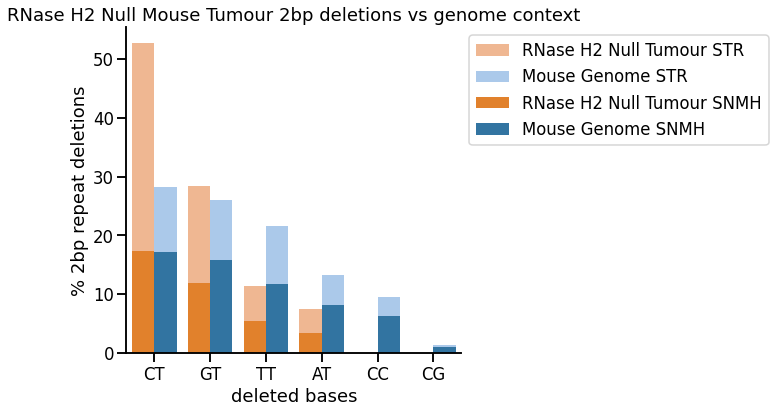

In [9]:
fix, ax = plt.subplots(figsize=(6, 6))
cat_order = ['CT', 'GT', 'TT', 'AT', 'CC', 'CG']
pal = sns.color_palette('pastel', 2)[::-1]
sns.barplot(
    ax=ax,
    data=combined_2bp_six_cat_counts.groupby(
       ['deleted bases', 'Sample_type']
       )['Percent'].sum().to_frame().reset_index(),
    x='deleted bases',
    order=cat_order,
    y='Percent',
    hue='Sample_type',
    hue_order=['RNase H2 Null Tumour', 'Mouse Genome'],
    palette=pal)
pal = sns.color_palette(None, 2)[::-1]
sns.barplot(
    ax=ax,
    data=combined_2bp_six_cat_counts[combined_2bp_six_cat_counts.repeat_type == 'SNMH'].groupby(
       ['deleted bases', 'Sample_type']
       )['Percent'].sum().to_frame().reset_index(),
    x='deleted bases',
    order=cat_order,
    y='Percent',
    hue='Sample_type',
    hue_order=['RNase H2 Null Tumour', 'Mouse Genome'],
    palette=pal)
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lbl in labels[:2]:
    lbl = lbl + ' STR'
    new_labels.append(lbl)
for lbl in labels[2:]:
    lbl = lbl + ' SNMH'
    new_labels.append(lbl)
plt.legend(handles, new_labels, bbox_to_anchor=(1.0, 1.0))
sns.despine()
plt.ylabel("% 2bp repeat deletions")
plt.title("RNase H2 Null Mouse Tumour 2bp deletions vs genome context")

# Read in repeat counts for yeast genome

In [16]:
tmp_counts = defaultdict(int)
yeast_genome_counts = defaultdict(list)
for txt in glob.glob("data/genome_scans/rpt_counts/GSE56939_L03_ref_v2_*.counts.txt"):
    with open(txt, 'rt') as fh:
        for line in fh:
            count, rpt = line.split()
            tmp_counts[rpt] += int(count)
for k, v in tmp_counts.items():
    rpt_type, rpt_len, rpt_unit = k.split(',')
    yeast_genome_counts['repeat_type'].append(rpt_type)
    yeast_genome_counts['repeat_length'].append(int(rpt_len))
    yeast_genome_counts['repeat_unit'].append(rpt_unit)
    yeast_genome_counts['Count'].append(v)
yeast_genome_counts = pd.DataFrame.from_dict(yeast_genome_counts)
yeast_genome_counts['deletion_length'] = yeast_genome_counts.repeat_unit.apply(
    lambda x: len(x))
yeast_genome_counts['repeat_length_cat'] = yeast_genome_counts.repeat_length.apply(
    lambda x: str(x) if x < 5 else ">4")
yeast_genome_counts['N_repeats'] = yeast_genome_counts.apply(
    lambda x: 1 if x.repeat_type == 'Imperfect'
    else x.repeat_length // x.deletion_length - 1,
    axis=1)
yeast_genome_counts['total_bp'] = yeast_genome_counts.repeat_length * yeast_genome_counts.Count
yeast_genome_counts

repeat_type  repeat_length repeat_unit  Count  deletion_length  \
0      Imperfect              5        AAAA  37154                4   
1      Imperfect              5        AAAC  15101                4   
2      Imperfect              5        AAAG  19699                4   
3      Imperfect              5        AAAT  24475                4   
4      Imperfect              5        AACA  18756                4   
...          ...            ...         ...    ...              ...   
9785     Perfect              9          GT     29                2   
9786     Perfect              9          TA    223                2   
9787     Perfect              9          TC     66                2   
9788     Perfect              9          TG     35                2   
9789     Perfect              9          TT    641                2   

     repeat_length_cat  N_repeats  total_bp  
0                   >4          1    185770  
1                   >4          1     75505  
2                   >4          1     98495  
3                   >4          1    122375  
4                   >4          1     93780  
...                ...        ...       ...  
9785                >4          3       261  
9786                >4          3      2007  
9787                >4          3       594  
9788                >4          3       315  
9789                >4          3      5769  

[9790 rows x 8 columns]

In [41]:
yeast_2bp_rpt_counts = yeast_genome_counts[(yeast_genome_counts.deletion_length == 2) &
                                           (yeast_genome_counts.repeat_type == 'Perfect')].copy()
yeast_2bp_rpt_counts['two_bp_six_categories'] = yeast_2bp_rpt_counts.repeat_unit.map(
    six_cats_from_2bp_repeat_unit)
yeast_2bp_six_cat_counts = yeast_2bp_rpt_counts.groupby(
    ['two_bp_six_categories'])['total_bp'].sum().reset_index()
total = yeast_2bp_six_cat_counts.total_bp.sum()
yeast_2bp_six_cat_counts['Percent'] = yeast_2bp_six_cat_counts.total_bp.apply(lambda x: 100 * x/total)
yeast_2bp_six_cat_counts['Count'] = yeast_2bp_six_cat_counts.total_bp
yeast_2bp_six_cat_counts['Sample_type'] = 'Yeast Genome'
yeast_2bp_six_cat_counts

two_bp_six_categories  total_bp    Percent   Count   Sample_type
0                    AT    553962  19.855874  553962  Yeast Genome
1                    CC    101728   3.646276  101728  Yeast Genome
2                    CG     78758   2.822953   78758  Yeast Genome
3                    CT    590983  21.182832  590983  Yeast Genome
4                    GT    466303  16.713878  466303  Yeast Genome
5                    TT    998181  35.778187  998181  Yeast Genome

# rnh201Δ pol2-M644G yeast

In [43]:
pol2_indels = pd.read_csv("data/pol2_m644g_rnh201_delta_yeast/pol2_M644G_rnh201_dnms.indels.csv")
pol2_2bp_rpt_dels = pol2_indels[(pol2_indels.variant_type == 'Del') &
                                 (pol2_indels.variant_length == 2) &
                                 (pol2_indels.repeat_type == 'Perfect')].copy()
pol2_2bp_rpt_dels['deleted_bases'] = pol2_2bp_rpt_dels.ref.apply(
    lambda x: x[1:])
pol2_2bp_rpt_dels['two_bp_six_categories'] = pol2_2bp_rpt_dels.deleted_bases.map(
    six_cats_from_2bp_repeat_unit)
pol2_2bp_rpt_dels.head(10)

chrom     pos         qual  ref alt  n_alleles variant_type  \
0   chr10_ref_v2  173081  1838.859985  AAG   A          2          Del   
1   chr10_ref_v2  173090  1747.859985  TTC   T          2          Del   
3   chr10_ref_v2  190627  1640.859985  CCA   C          2          Del   
4   chr10_ref_v2  233817  6914.589844  AAC   A          2          Del   
5   chr10_ref_v2  262822   926.859985  GTC   G          2          Del   
6   chr10_ref_v2  302067  1838.859985  GCT   G          2          Del   
7   chr10_ref_v2  520725  9099.580078  TGA   T          2          Del   
8   chr10_ref_v2   54998  9142.320312  GCT   G          2          Del   
10  chr10_ref_v2  724357  5573.560059  TAG   T          2          Del   
11  chr10_ref_v2   73860  3401.860107  CTG   C          2          Del   

   repeat_type repeat_unit  repeat_length  \
0      Perfect          AG              6   
1      Perfect          TC              8   
3      Perfect          CA              4   
4      Perfect          AC              4   
5      Perfect          TC              6   
6      Perfect          CT              4   
7      Perfect          GA              4   
8      Perfect          CT              4   
10     Perfect          AG              6   
11     Perfect          TG              4   

                                      sequence  variant_length cosmic_class  \
0   tgagcaaaatagagaaggaaAGagaggattctctctctgagt               2    2:Del:R:2   
1   tagagaaggaaagagaggatTCtctctctgagtaaaatcgat               2    2:Del:R:3   
3   tggcctccaaacccaggttcCAcagtcataacaagagccata               2    2:Del:R:1   
4   gaatattctttttgtcactaACacaaccattctataaattga               2    2:Del:R:1   
5   cttttcgtatccggcatttgTCtctctgaagaaacatccatg               2    2:Del:R:2   
6   ttaatttgaatctttttctgCTctgtttcctccatttttttc               2    2:Del:R:1   
7   gtctttagtagcttgtctttGAgagtcgttgaaataagctgg               2    2:Del:R:1   
8   caagaaattacagaatgacgCTctgttgtgtgaattgatatt               2    2:Del:R:1   
10  tcaaaaatcaaaataattttAGagagtctcatcaaccttcgc               2    2:Del:R:2   
11  tctttttttcagatggagacTGtgatcgggtagcgcatgatg               2    2:Del:R:1   

   Simple_Categorization deleted_bases two_bp_six_categories  
0        2-5 bp deletion            AG                    CT  
1        2-5 bp deletion            TC                    CT  
3        2-5 bp deletion            CA                    GT  
4        2-5 bp deletion            AC                    GT  
5        2-5 bp deletion            TC                    CT  
6        2-5 bp deletion            CT                    CT  
7        2-5 bp deletion            GA                    CT  
8        2-5 bp deletion            CT                    CT  
10       2-5 bp deletion            AG                    CT  
11       2-5 bp deletion            TG                    GT

In [51]:
pol2_2bp_six_cat_counts = pol2_2bp_rpt_dels.groupby(
    'two_bp_six_categories')['two_bp_six_categories'].count().to_frame()
pol2_2bp_six_cat_counts.columns = ['Count']
pol2_2bp_six_cat_counts.reset_index(inplace=True)
total = pol2_2bp_six_cat_counts.Count.sum()
pol2_2bp_six_cat_counts['Percent'] = pol2_2bp_six_cat_counts.Count.apply(
    lambda x: 100 * x/total)
pol2_2bp_six_cat_counts['Sample_type'] = 'rnh201Δ pol2-M644G'
combined_2bp_six_cat_counts = pol2_2bp_six_cat_counts.append(
    yeast_2bp_six_cat_counts)
combined_2bp_six_cat_counts.drop('total_bp', inplace=True, axis=1)
combined_2bp_six_cat_counts.columns = ['deleted bases' 
    if x == 'two_bp_six_categories' else x 
    for x in combined_2bp_six_cat_counts.columns]
combined_2bp_six_cat_counts

deleted bases   Count    Percent         Sample_type
0            CT      53  60.227273  rnh201Δ pol2-M644G
1            GT      32  36.363636  rnh201Δ pol2-M644G
2            TT       3   3.409091  rnh201Δ pol2-M644G
0            AT  553962  19.855874        Yeast Genome
1            CC  101728   3.646276        Yeast Genome
2            CG   78758   2.822953        Yeast Genome
3            CT  590983  21.182832        Yeast Genome
4            GT  466303  16.713878        Yeast Genome
5            TT  998181  35.778187        Yeast Genome

In [55]:
combined_2bp_six_cat_counts.to_csv(os.path.join(
    out_dir,
    "pol2-M644G_rnh201_delta_2bp_deletion_dinucleotide_counts.csv"),
                                   index=False)

In [54]:
fix, ax = plt.subplots(figsize=(8, 6))
cat_order = ['CT', 'GT', 'TT', 'AT', 'CC', 'CG']
pal = sns.color_palette(None, 2)[::-1]
sns.barplot(
    ax=ax,
    data=combined_2bp_six_cat_counts,
    x='deleted bases',
    order=cat_order,
    y='Percent',
    hue='Sample_type',
    hue_order=['rnh201Δ pol2-M644G', 'Yeast Genome'],
    palette=pal)
plt.legend(loc='upper right')
sns.despine()
plt.ylabel("% 2bp repeat deletions")
plt.title("rnh201Δ pol2-M644G yeast 2bp STR deletions vs genome context")

Text(0.5, 1.0, 'rnh201Δ pol2-M644G yeast 2bp STR deletions vs genome context')